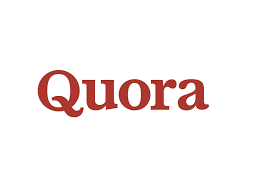


# Identifying Duplicate Questions on Quora

#### - Aradhana Jayaprakash, Sri Harika Cherukuri

##### Quora is a popular platform for people to ask and answer questions on various topics, but it can be challenging to find the most relevant answers when there are multiple duplicate questions. Identifying and removing duplicate questions can help to improve the quality of the content and enhance the user experience on the platform. The aim of this project is to develop a classification model that can accurately identify duplicate questions on Quora, a popular question and answer platform. 


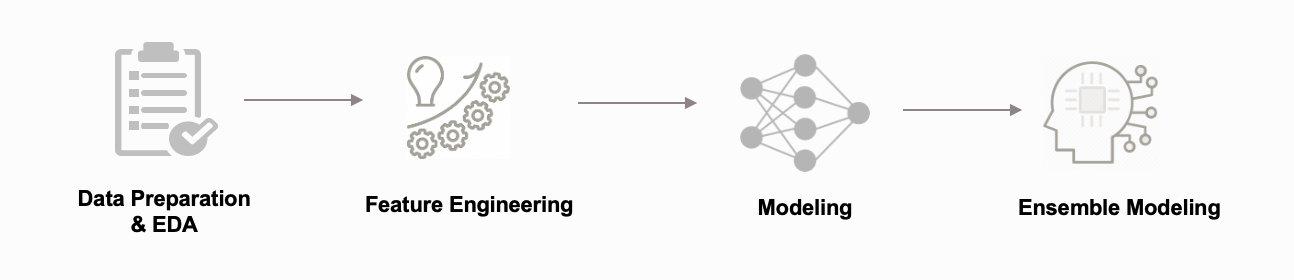

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
from nltk.stem import WordNetLemmatizer, PorterStemmer
nltk.download('wordnet')
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import re
from difflib import SequenceMatcher
from fuzzywuzzy import fuzz
from pyxdameraulevenshtein import damerau_levenshtein_distance as edit_distance
from Levenshtein import distance

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sriharikacherukuri/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sriharikacherukuri/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sriharikacherukuri/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
train=pd.read_csv('train.csv',encoding='utf-8')
train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


### Exploratory Data Analysis

In [3]:
# removing nulls
print(train.isnull().sum().sum())
train.info()
train = train[~train.isna().any(axis=1)]
print(train.isnull().sum().sum())
train.info()

3
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB
0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 404287 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404287 non-null  int64 
 1   qid1          404287 non-null  int64 
 2   qid2          404287 non-null  int64 
 3   question1     404287 non-null  object
 4   question2     404287 non-null  object
 5   is_duplicate  404287 non-null  int64 
dtypes: int64(4), object(2)
memory us

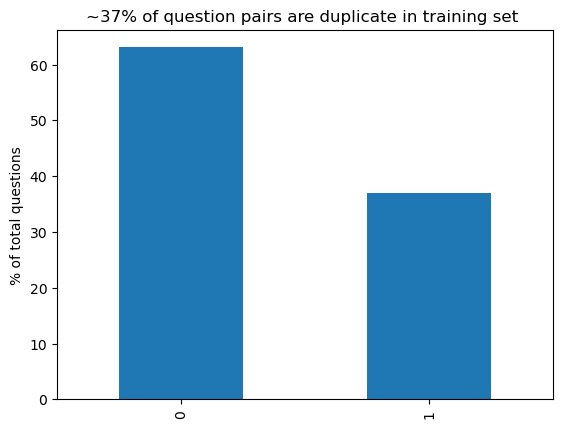

In [4]:
# Count the number of occurrences of each value in 'is_duplicate' column
value_counts = train['is_duplicate'].value_counts()

# Plot the bar chart with y-axis as percentages
plt.figure()
plt.ylabel('% of total questions')
plt.title('~37% of question pairs are duplicate in training set ')
(value_counts / train['is_duplicate'].count() * 100).plot(kind='bar')
plt.show()

#### The data set is not balanced since 63% of the question pairs are not duplicates and 37% are duplicates. There is a difference in the distribution of two classes.

In [5]:
#checking for duplicate question pairs

pair_duplicates = train[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

print ("Number of duplicate question pairs",(pair_duplicates).shape[0] - train.shape[0])

Number of duplicate question pairs 0


In [6]:
# uniqueness of the questions
qid = pd.Series(train['qid1'].tolist() + train['qid2'].tolist())
print('Total Number of questions:',qid.shape[0])
print('Number of unique questions:',np.unique(qid).shape[0])
x = qid.value_counts()>1
print('Number of repeated questions:',x[x].shape[0])

Total Number of questions: 808574
Number of unique questions: 537929
Number of repeated questions: 111778


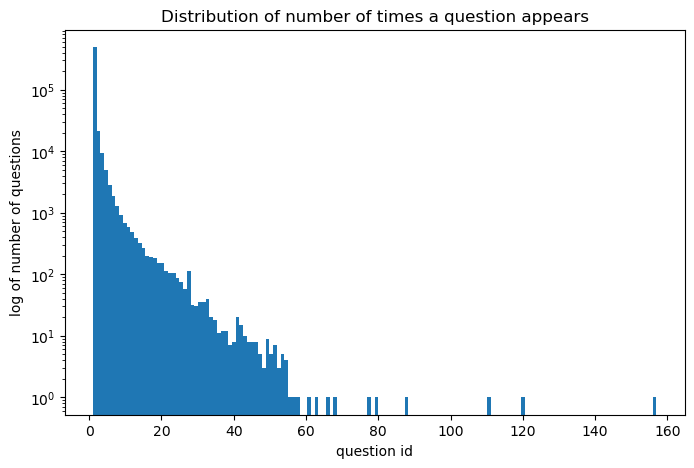

In [7]:
plt.figure(figsize=(8,5))
plt.hist(qid.value_counts().values,bins=150)
plt.yscale('log')
plt.xlabel('question id')
plt.ylabel('log of number of questions')
plt.title('Distribution of number of times a question appears')
plt.show()

### Feature Engineering

q1_len = length of q1

q2_len = length of q2

q1_num_words = number of words in q1

q2_num_words = number of words in q2

common_words = number of common words between q1 and q2

total_words = total number of words in q1 and q2

shared_words = common_words/total_words

freq_q1 = number of times q1 appeared in train

freq_q2 = number of times q2 appeared in train

sum_freq = freq_q1+freq_q2

diff_freq = freq_q1-freq_q2


##### token_based_features: The list of features are


Ratio of common non-stopwords to the minimum number of non-stopwords in the two questions.

Ratio of common non-stopwords to the maximum number of non-stopwords in the two questions.

Ratio of common stopwords to the minimum number of stopwords in the two questions.

Ratio of common stopwords to the maximum number of stopwords in the two questions.

Ratio of common tokens to the minimum number of tokens in the two questions.

Ratio of common tokens to the maximum number of tokens in the two questions.

Binary feature indicating if the last token in q1 is the same as the last token in q2.

Binary feature indicating if the first token in q1 is the same as the first token in q2.

Absolute difference in length between q1 and q2.

Average length of tokens in both q1 and q2.

In [8]:
def common_words(row):
    """
    Returns the number of common words between two input sentences (question1 and question2).
    
    Args:
    row: a pandas Series object representing a row in a DataFrame, containing columns 'question1' and 'question2'
    
    Returns:
    An integer representing the number of common words between the two input sentences.
    """
    wq1 = set(map(lambda x: x.lower().strip(),row['question1'].split()))
    wq2 = set(map(lambda x: x.lower().strip(),row['question2'].split()))
    return len(wq1 & wq2)

In [9]:
def total_words(row):
    """
    Returns the total number of words in two given questions of a DataFrame row.
    
    Parameters:
    row (pandas.DataFrame): A row of a DataFrame containing two questions as columns 'question1' and 'question2'.
    
    Returns:
    int: The total number of words in the two questions.
    """
    wq1 = set(map(lambda x: x.lower().strip(), row['question1'].split()))
    wq2 = set(map(lambda x: x.lower().strip(), row['question2'].split()))
    return len(wq1) + len(wq2)

In [10]:
def preprocess(text):
    """
    Preprocesses text data by converting to lowercase, replacing contractions, converting numbers to short forms,
    removing special characters, and stemming words using Porter Stemmer.

    Args:
        text (str): Text data to be preprocessed.

    Returns:
        str: Preprocessed text.
    """
    # Convert to lowercase
    text = text.lower()
    
    contractions = {
    "can't": "cannot",
    "won't": "will not",
    "n't": "not",
    "it's": "it is",
    "'s": "is",
    "'ve": "have",
    "'re": "are",
    "'ll": "will",
    "what's": "what is",
    "i'm": "i am",
    "he's": "he is",
    "she's": "she is"}

    # Replace contractions
    text = re.sub(r"won't|can't|n't|what's|it's|i'm|he's|she's|'s|'ve|'re|'ll", lambda match: contractions[match.group(0)], text)

    # Convert numbers to short forms
    text = re.sub(r"([0-9]+)000000", r"\1m", text)
    text = re.sub(r"([0-9]+)000", r"\1k", text)

    # Remove special characters and stem words
    porter = PorterStemmer()
    text = re.sub(r"[^a-zA-Z0-9]+", " ", text)
    text = " ".join([porter.stem(word) for word in text.split()])

    # Remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()

    return text

In [11]:
def get_token_features(q1, q2):
    """
    Calculates features based on the comparison of tokens in two input strings.
    Returns a list of 10 features.
    """
    token_features = [0.0]*10
    SAFE_DIV = 0.0001 
    
    # Converting the Sentence into Tokens: 
    q1_tokens = set(q1.split())
    q2_tokens = set(q2.split())

    if not q1_tokens or not q2_tokens:
        return token_features
    

    STOP_WORDS = set(stopwords.words('english'))
    # Get the non-stopwords and stopwords in Questions
    q1_words, q2_words = q1_tokens - STOP_WORDS, q2_tokens - STOP_WORDS
    q1_stops, q2_stops = q1_tokens & STOP_WORDS, q2_tokens & STOP_WORDS
    
    # Get the common non-stopwords, stopwords and tokens from Question pair
    common_word_count = len(q1_words & q2_words)
    common_stop_count = len(q1_stops & q2_stops)
    common_token_count = len(q1_tokens & q2_tokens)
    
    q1_tokens = list(q1_tokens)
    q2_tokens = list(q2_tokens)
    
    # Calculate token features
    len_q1_words, len_q2_words = len(q1_words), len(q2_words)
    len_q1_stops, len_q2_stops = len(q1_stops), len(q2_stops)
    len_q1_tokens, len_q2_tokens = len(q1_tokens), len(q2_tokens)
    token_features[0] = common_word_count / (min(len_q1_words, len_q2_words) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len_q1_words, len_q2_words) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len_q1_stops, len_q2_stops) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len_q1_stops, len_q2_stops) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len_q1_tokens, len_q2_tokens) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len_q1_tokens, len_q2_tokens) + SAFE_DIV)
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    token_features[8] = abs(len_q1_tokens - len_q2_tokens)
    token_features[9] = (len_q1_tokens + len_q2_tokens)/2
    
    return token_features

In [12]:
def get_longest_substr_ratio(a: str, b: str) -> float:
    """
    Returns the ratio of the length of the longest common substring between two strings to the length of the smaller string plus one.
    
    Args:
    a (str): the first string
    b (str): the second string
    
    Returns:
    float: the ratio of the length of the longest common substring to the length of the smaller string plus one.
    """
    seq_matcher = SequenceMatcher(None, a, b)
    match = seq_matcher.find_longest_match(0, len(a), 0, len(b))
    if match.size == 0:
        return 0
    return match.size / (min(len(a), len(b)) + 1)

In [13]:
def extract_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Preprocesses the questions in the input DataFrame, computes token and fuzzy features, and
    merges these features with the original DataFrame.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing "question1" and "question2" columns
    
    Returns:
    pd.DataFrame: DataFrame with additional columns for token and fuzzy features
    """
    # Preprocess questions
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    # Compute token features and merge with DataFrame
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    token_feature_names = ["cwc_min", "cwc_max", "csc_min", "csc_max", "ctc_min", "ctc_max", "last_word_eq", "first_word_eq", "abs_len_diff", "mean_len"]
    for i, feature_name in enumerate(token_feature_names):
        df[feature_name] = token_features.apply(lambda x: x[i])

    # Compute fuzzy features and merge with DataFrame
    df["token_set_ratio"] = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    df["token_sort_ratio"] = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"] = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"] = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"] = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)

    return df


In [14]:
train['q1_len'] = train.question1.apply(len)
train['q2_len'] = train.question2.apply(len)
train['q1_num_words'] = train.question1.apply(lambda sent: len(sent.split()))
train['q2_num_words'] = train.question2.apply(lambda sent: len(sent.split()))
train['common_words'] = train.apply(common_words,axis=1)
train['total_words'] = train.apply(total_words,axis=1)
train['shared_words'] = round(train.common_words / train.total_words,2)
train['freq_q1'] = train.groupby('qid1')['qid1'].transform('count')
train['freq_q2'] = train.groupby('qid2')['qid2'].transform('count')
train['sum_freq'] = train['freq_q1']+train['freq_q2']
train['diff_freq'] = abs(train['freq_q1']-train['freq_q2'])

In [15]:
df_features = extract_features(train)

In [16]:
df_features.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'q1_len', 'q2_len', 'q1_num_words', 'q2_num_words', 'common_words',
       'total_words', 'shared_words', 'freq_q1', 'freq_q2', 'sum_freq',
       'diff_freq', 'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min',
       'ctc_max', 'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio'],
      dtype='object')

In [17]:
df_features.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guid to invest in sha...,what is the step by step guid to invest in sha...,0,66,57,14,12,...,0.916659,1.0,1.0,1.0,11.5,100,92,92,100,0.982143
1,1,3,4,what is the stori of kohinoor koh i noor diamond,what would happen if the indian govern stole t...,0,51,88,8,13,...,0.499996,1.0,0.0,4.0,12.0,86,65,67,75,0.571429
2,2,5,6,how can i increas the speed of my internet con...,how can internet speed be increas by hack thro...,0,73,59,14,10,...,0.357140,0.0,1.0,4.0,12.0,73,66,54,56,0.188679
3,3,7,8,whi am i mental veri lone how can i solv it,find the remaind when math 23 24 math is divid...,0,50,65,11,9,...,0.000000,0.0,0.0,0.0,10.0,38,37,35,40,0.045455
4,4,9,10,which one dissolv in water quikli sugar salt m...,which fish would surviv in salt water,0,76,39,13,7,...,0.307690,1.0,0.0,6.0,10.0,68,49,45,54,0.157895


In [ ]:
# n = df_features.shape[0]
# sns.pairplot(df_features[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
# plt.show()


In [69]:
rest_data = df_features.drop(['id','qid1','qid2','question1','question2'],axis=1)
rest_data.head()

,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,common_words,total_words,shared_words,freq_q1,freq_q2,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,66,57,14,12,10,23,0.43,1,1,...,0.916659,1.0,1.0,1.0,11.5,100,92,92,100,0.982143
1,0,51,88,8,13,4,20,0.20,4,1,...,0.499996,1.0,0.0,4.0,12.0,86,65,67,75,0.571429
2,0,73,59,14,10,4,24,0.17,1,1,...,0.357140,0.0,1.0,4.0,12.0,73,66,54,56,0.188679
3,0,50,65,11,9,0,19,0.00,1,1,...,0.000000,0.0,0.0,0.0,10.0,38,37,35,40,0.045455
4,0,76,39,13,7,2,20,0.10,3,1,...,0.307690,1.0,0.0,6.0,10.0,68,49,45,54,0.157895


In [70]:
ques_df = df_features[['question1','question2']]
ques_df.head()

,question1,question2
0,what is the step by step guid to invest in sha...,what is the step by step guid to invest in sha...
1,what is the stori of kohinoor koh i noor diamond,what would happen if the indian govern stole t...
2,how can i increas the speed of my internet con...,how can internet speed be increas by hack thro...
3,whi am i mental veri lone how can i solv it,find the remaind when math 23 24 math is divid...
4,which one dissolv in water quikli sugar salt m...,which fish would surviv in salt water


In [71]:
questions = np.array(list(ques_df.question1) + list(ques_df.question2))
cv = CountVectorizer(max_features=50)
ques1_arr, ques2_arr = np.vsplit(cv.fit_transform(questions).toarray(),2)

In [119]:
current_cols

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,  0,
             1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
            35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
           dtype='int64')

In [72]:
q1_temp = pd.DataFrame(ques1_arr)
q2_temp = pd.DataFrame(ques2_arr)
ques = pd.concat([q1_temp,q2_temp],axis=1)
ques.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0


In [73]:
current_cols = ques.columns

# Generate new column names from 0 to 50 in string format
new_cols = [str(i) for i in range(50)]

# Rename columns using a dictionary mapping old column names to new column names
ques.rename(columns=dict(zip(current_cols, new_cols)), inplace=True)

# Display the updated DataFrame with renamed columns
print(ques)

        0  1  2  3  4  5  6  7  8  9  ...  40  41  42  43  44  45  46  47  48  \
0       0  0  0  0  0  0  0  0  0  0  ...   1   0   0   0   0   0   0   0   0   
1       0  0  0  0  0  0  0  0  0  0  ...   1   0   0   0   0   0   0   1   0   
2       0  0  0  0  0  0  0  0  1  0  ...   0   0   0   0   0   0   0   0   0   
3       0  0  0  0  0  0  0  0  1  0  ...   0   1   0   0   0   0   0   0   0   
4       0  0  1  0  0  0  0  0  0  0  ...   0   0   0   1   0   0   0   1   0   
...    .. .. .. .. .. .. .. .. .. ..  ...  ..  ..  ..  ..  ..  ..  ..  ..  ..   
404282  0  0  0  1  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   0   
404283  0  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   0   
404284  0  0  0  0  0  0  0  0  0  0  ...   1   0   0   0   0   0   0   0   0   
404285  0  1  0  0  0  0  0  0  0  0  ...   0   0   0   1   0   0   0   0   0   
404286  0  0  0  0  0  0  0  0  0  0  ...   1   0   0   0   0   0   1   0   0   

        49  
0        0  
1

In [74]:
ques.index = rest_data.index

In [75]:
df = pd.concat([rest_data,ques],axis=1)
df.head()

,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,common_words,total_words,shared_words,freq_q1,freq_q2,...,40,41,42,43,44,45,46,47,48,49
0,0,66,57,14,12,10,23,0.43,1,1,...,1,0,0,0,0,0,0,0,0,0
1,0,51,88,8,13,4,20,0.20,4,1,...,1,0,0,0,0,0,0,1,0,0
2,0,73,59,14,10,4,24,0.17,1,1,...,0,0,0,0,0,0,0,0,0,0
3,0,50,65,11,9,0,19,0.00,1,1,...,0,1,0,0,0,0,0,0,0,0
4,0,76,39,13,7,2,20,0.10,3,1,...,0,0,0,1,0,0,0,1,0,0


 ### Classification Machine Learning Models

#### Training

In [76]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier

In [77]:
X = df.drop('is_duplicate',axis=1)
y = df.is_duplicate

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,shuffle=True,random_state=101)

In [79]:
scaler = MinMaxScaler()
features = X_train.columns
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_train = pd.DataFrame(scaled_X_train,columns=features)
scaled_X_train.head()

,q1_len,q2_len,q1_num_words,q2_num_words,common_words,total_words,shared_words,freq_q1,freq_q2,sum_freq,...,40,41,42,43,44,45,46,47,48,49
0,0.065916,0.036815,0.056452,0.038136,0.097561,0.097561,0.44,0.000000,0.000000,0.000000,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.136656,0.038527,0.088710,0.038136,0.073171,0.115854,0.28,0.000000,0.000000,0.000000,...,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.056270,0.029966,0.056452,0.029661,0.121951,0.085366,0.62,0.755102,0.016807,0.251613,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.064309,0.017979,0.048387,0.012712,0.024390,0.054878,0.18,0.000000,0.025210,0.019355,...,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.104502,0.023973,0.112903,0.029661,0.146341,0.115854,0.58,0.000000,0.042017,0.032258,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [80]:
scaled_X_test = scaler.transform(X_test)
scaled_X_test = pd.DataFrame(scaled_X_test,columns=features)
scaled_X_test.head()

,q1_len,q2_len,q1_num_words,q2_num_words,common_words,total_words,shared_words,freq_q1,freq_q2,sum_freq,...,40,41,42,43,44,45,46,47,48,49
0,0.078778,0.059075,0.064516,0.055085,0.121951,0.121951,0.46,0.020408,0.00000,0.006452,...,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.083601,0.041096,0.080645,0.038136,0.097561,0.115854,0.38,0.000000,0.05042,0.038710,...,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.131833,0.053938,0.088710,0.038136,0.024390,0.121951,0.10,0.000000,0.00000,0.000000,...,0.25,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.104502,0.047945,0.104839,0.038136,0.195122,0.128049,0.70,0.000000,0.00000,0.000000,...,0.25,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.072347,0.026541,0.056452,0.021186,0.121951,0.073171,0.72,0.000000,0.00000,0.000000,...,0.00,0.00,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0


In [81]:
def train_and_evaluate_model(model):
    model.fit(scaled_X_train,y_train)
    pred = model.predict(scaled_X_test)
    print(classification_report(y_test,pred))
    cm = confusion_matrix(y_test, pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
    disp.plot()
    precision_recall_curve(y_test,pred)

              precision    recall  f1-score   support

           0       0.81      0.88      0.84     51015
           1       0.76      0.65      0.70     29843

    accuracy                           0.79     80858
   macro avg       0.78      0.76      0.77     80858
weighted avg       0.79      0.79      0.79     80858



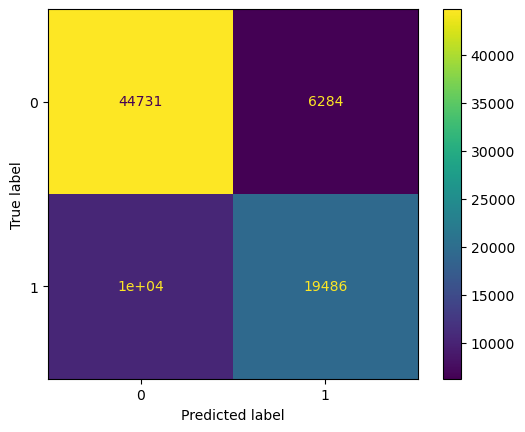

In [82]:
# Logistic Regression
train_and_evaluate_model(LogisticRegression(max_iter=1000))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88     51015
           1       0.82      0.74      0.78     29843

    accuracy                           0.84     80858
   macro avg       0.84      0.82      0.83     80858
weighted avg       0.84      0.84      0.84     80858



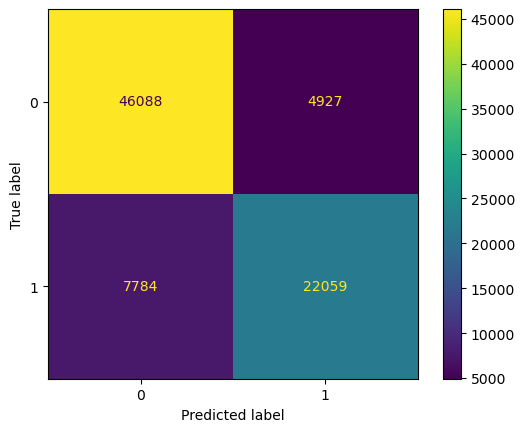

In [83]:
# Random Forest
train_and_evaluate_model(RandomForestClassifier())

              precision    recall  f1-score   support

           0       0.84      0.89      0.86     51015
           1       0.79      0.70      0.74     29843

    accuracy                           0.82     80858
   macro avg       0.81      0.80      0.80     80858
weighted avg       0.82      0.82      0.82     80858



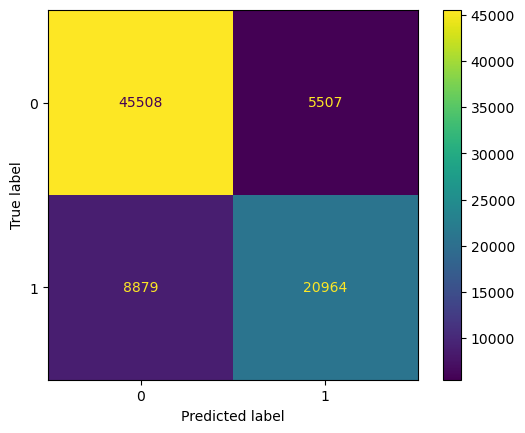

In [84]:
# Gradient Boosting
train_and_evaluate_model(GradientBoostingClassifier())

              precision    recall  f1-score   support

           0       0.84      0.90      0.87     51015
           1       0.81      0.72      0.76     29843

    accuracy                           0.83     80858
   macro avg       0.83      0.81      0.81     80858
weighted avg       0.83      0.83      0.83     80858



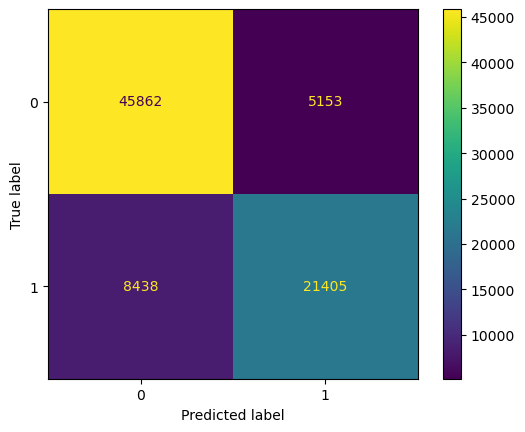

In [85]:
# Initialize models
lr = LogisticRegression(max_iter=1000)
rf = RandomForestClassifier()
gb = GradientBoostingClassifier()

# Create the ensemble model using VotingClassifier
ensemble_model = VotingClassifier(estimators=[('lr', lr), ('rf', rf), ('gb', gb)], voting='hard')

# Train and evaluate the ensemble model
train_and_evaluate_model(ensemble_model)

#### The VotingClassifier performs best when the individual models have different strengths and weaknesses. If the individual models are too similar, combining them may not improve the overall performance much which is happening in our case. 

#### Train evaluation metrics

In [146]:
# Make predictions using the trained model
pred = ensemble_model.predict(scaled_X_train)


              precision    recall  f1-score   support

           0       0.87      0.93      0.90    204009
           1       0.86      0.77      0.81    119420

    accuracy                           0.87    323429
   macro avg       0.87      0.85      0.86    323429
weighted avg       0.87      0.87      0.87    323429



(array([0.36923096, 0.8645801 , 1.        ]),
 array([1.        , 0.76958633, 0.        ]),
 array([0, 1]))

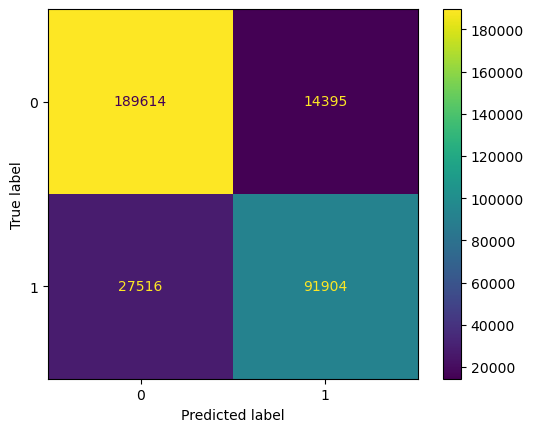

In [148]:
# Calculate evaluation metrics
print(classification_report(y_train, pred))
cm = confusion_matrix(y_train, pred, labels=ensemble_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ensemble_model.classes_)
disp.plot()
precision_recall_curve(y_train, pred)

#### Testing - Unseen data

In [91]:
# Set a random seed for reproducibility
np.random.seed(123)

# Count the total number of rows in the test file
nrows = sum(1 for line in open('test.csv')) - 1  # Subtract 1 to exclude the header row

# Generate a random list of row indices to skip over
skiprows = np.random.choice(np.arange(1, nrows+1), replace=False, size=nrows-300000)

# Read in the test data, skipping over the randomly selected rows
test_df = pd.read_csv('test.csv', skiprows=skiprows)

In [92]:
# removing nulls
print(test_df.isnull().sum().sum())
test_df.info()
test_df = test_df[~test_df.isna().any(axis=1)]
print(test_df.isnull().sum().sum())
test_df.info()

0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   test_id    300000 non-null  int64 
 1   question1  300000 non-null  object
 2   question2  300000 non-null  object
dtypes: int64(1), object(2)
memory usage: 6.9+ MB
0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 300000 entries, 0 to 299999
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   test_id    300000 non-null  int64 
 1   question1  300000 non-null  object
 2   question2  300000 non-null  object
dtypes: int64(1), object(2)
memory usage: 9.2+ MB


In [97]:
# Create a set of all unique questions in the DataFrame
unique_questions = set(test_df['question1']).union(set(test_df['question2']))

# Create a dictionary that maps each question to its corresponding id
question_to_id = {question: idx+1 for idx, question in enumerate(unique_questions)}

# Use the dictionary to generate qid1 and qid2 columns
test_df['qid1'] = test_df['question1'].map(question_to_id)
test_df['qid2'] = test_df['question2'].map(question_to_id)

# Display the updated DataFrame with qid1 and qid2 columns
print(test_df.head())

   test_id                                          question1  \
0        4                   How "aberystwyth" start reading?   
1       29  Are there Doctor Who references in the Muse so...   
2       41     Which age is the best age to what get married?   
3       60       What are examples of closed source software?   
4      112  What are some good ways to network with people...   

                                           question2  q1_len  q2_len  \
0                     How their can I start reading?      32      30   
1  In "The Big Bang" episode of Doctor Who, how d...      70     151   
2           What is the best age to get for a woman?      46      40   
3              What is open source and close source?      44      37   
4  What pictures are some good ways to network wi...      98     101   

   q1_num_words  q2_num_words  common_words  total_words  shared_words  \
0             4             6             3           10          0.30   
1            12            2

In [98]:
test_df['q1_len'] = test_df.question1.apply(len)
test_df['q2_len'] = test_df.question2.apply(len)
test_df['q1_num_words'] = test_df.question1.apply(lambda sent: len(sent.split()))
test_df['q2_num_words'] = test_df.question2.apply(lambda sent: len(sent.split()))
test_df['common_words'] = test_df.apply(common_words,axis=1)
test_df['total_words'] = test_df.apply(total_words,axis=1)
test_df['shared_words'] = round(test_df.common_words / test_df.total_words,2)
test_df['freq_q1'] = test_df.groupby('qid1')['qid1'].transform('count')
test_df['freq_q2'] = test_df.groupby('qid2')['qid2'].transform('count')
test_df['sum_freq'] = test_df['freq_q1']+test_df['freq_q2']
test_df['diff_freq'] = abs(test_df['freq_q1']-test_df['freq_q2'])

In [99]:
df_features_test = extract_features(test_df)

In [101]:
df_features_test.head(2)

,test_id,question1,question2,q1_len,q2_len,q1_num_words,q2_num_words,common_words,total_words,shared_words,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,4,how aberystwyth start read,how their can i start read,32,30,4,6,3,10,0.30,...,0.499992,0.0,0.0,2.0,5.0,70,62,65,65,0.407407
1,29,are there doctor who refer in the muse song kn...,in the big bang episod of doctor who how doe r...,70,151,12,29,5,38,0.13,...,0.239999,0.0,0.0,13.0,18.5,58,49,43,54,0.193548


In [102]:
rest_test_data = df_features_test.drop(['test_id', 'qid1', 'qid2', 'question1', 'question2'], axis=1)

In [114]:
test_question_counts.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [122]:
# Combine the test question columns into a single array
test_questions = np.array(list(df_features_test.question1) + list(df_features_test.question2))

# Use the CountVectorizer object to transform the test questions into a matrix of word counts
test_question_counts = cv.transform(test_questions)

# Split the test question counts into two arrays, one for each question
test_ques1_arr, test_ques2_arr = np.vsplit(test_question_counts.toarray(), 2)

# Create dataframes for the transformed test questions
test_q1_temp = pd.DataFrame(test_ques1_arr)
test_q2_temp = pd.DataFrame(test_ques2_arr)
test_ques = pd.concat([test_q1_temp, test_q2_temp], axis=1)

current_cols = test_ques.columns

# Rename columns using a dictionary mapping old column names to new column names
test_ques.rename(columns=dict(zip(current_cols, new_cols)), inplace=True)

# # Rename the columns using the same column names used for the training data
# test_ques.columns = new_cols

# Display the updated test dataframe with renamed columns
print(test_ques)

        0  1  2  3  4  5  6  7  8  9  ...  40  41  42  43  44  45  46  47  48  \
0       0  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   0   
1       0  0  0  1  0  0  0  0  0  0  ...   0   1   0   0   1   0   0   0   0   
2       0  0  0  0  0  0  0  1  0  0  ...   1   0   0   0   0   0   0   0   0   
3       0  0  0  1  0  0  0  0  0  0  ...   1   0   0   0   0   0   0   0   0   
4       0  0  0  1  0  0  0  0  0  0  ...   1   0   0   0   0   0   1   0   0   
...    .. .. .. .. .. .. .. .. .. ..  ...  ..  ..  ..  ..  ..  ..  ..  ..  ..   
299995  0  0  0  0  0  0  0  0  0  0  ...   1   0   0   0   0   0   0   0   0   
299996  0  0  0  0  0  0  0  0  0  0  ...   1   0   0   0   0   0   0   0   0   
299997  0  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   0   
299998  0  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   0   
299999  0  0  0  1  0  0  0  1  0  0  ...   1   0   0   0   0   0   0   0   0   

        49  
0        0  
1

In [123]:
test_ques.index = rest_test_data.index

In [124]:
df_test = pd.concat([rest_test_data,test_ques],axis=1)
df_test.head()

,q1_len,q2_len,q1_num_words,q2_num_words,common_words,total_words,shared_words,freq_q1,freq_q2,sum_freq,...,40,41,42,43,44,45,46,47,48,49
0,32,30,4,6,3,10,0.30,1,1,2,...,0,0,0,0,0,0,0,0,0,0
1,70,151,12,29,5,38,0.13,1,1,2,...,0,1,0,0,1,0,0,0,0,0
2,46,40,10,10,7,19,0.37,1,1,2,...,1,0,0,0,0,0,0,0,0,0
3,44,37,7,7,2,14,0.14,1,1,2,...,1,0,0,0,0,0,0,0,0,0
4,98,101,16,17,14,33,0.42,1,1,2,...,1,0,0,0,0,0,1,0,0,0


In [128]:
df.head()

,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,common_words,total_words,shared_words,freq_q1,freq_q2,...,40,41,42,43,44,45,46,47,48,49
0,0,66,57,14,12,10,23,0.43,1,1,...,1,0,0,0,0,0,0,0,0,0
1,0,51,88,8,13,4,20,0.20,4,1,...,1,0,0,0,0,0,0,1,0,0
2,0,73,59,14,10,4,24,0.17,1,1,...,0,0,0,0,0,0,0,0,0,0
3,0,50,65,11,9,0,19,0.00,1,1,...,0,1,0,0,0,0,0,0,0,0
4,0,76,39,13,7,2,20,0.10,3,1,...,0,0,0,1,0,0,0,1,0,0


In [130]:
# Scale the test set features using the same scaler used for the training set
scaled_test_features = scaler.transform(df_test)
scaled_test_features = pd.DataFrame(scaled_test_features, columns=features)

In [131]:
# Make predictions on the test set using the trained model
test_predictions = ensemble_model.predict(scaled_test_features)

In [132]:
df_test['is_duplicate'] = test_predictions

In [137]:
test_df = test_df.merge(df_test[['is_duplicate']], left_index=True, right_index=True)

In [141]:
test_df[['test_id','question1','question2', 'is_duplicate']].to_csv('test_predictions.csv', index=False)